# Mass Maps From Mass-Luminosity Inference Posterior

In this notebook we start to explore the potential of using a mass-luminosity relation posterior to refine mass maps. 

Content:
- [Math](#Math)
- [Imports, Constants, Utils, Data](#Imports,-Constants,-Utils,-Data)
- [Probability Functions](#Probability-Functions)
- [Results](#Results)
- [Discussion](#Discussion)

### Math

Infering mass from mass-luminosity relation posterior ...

\begin{align}
P(M|L_{obs},z,\sigma_L^{obs}) &= \iint P(M|\alpha, S, L_{obs}, z)P(\alpha, S|L_{obs},z,\sigma_L^{obs})\ d\alpha dS\\
&\propto \iiint P(L_{obs}| L,\sigma_L^{obs})P(L|M,\alpha,S,z)P(M|z)P(\alpha, S|L_{obs},z,\sigma_L^{obs})\ dLd\alpha dS\\
&\approx \frac{P(M|z)}{n_{\alpha,S}}\sum_{\alpha,S \sim P(\alpha, S|L_{obs},z,\sigma_L^{obs})}\left( \frac{1}{n_L}\sum_{L\sim P(L|M,\alpha,S,z)}P(L_{obs}|L,\sigma_L^{obs})\right)\\
&= \frac{P(M|z)}{n_{\alpha,S}}\sum_{\alpha,S \sim P(\alpha, S|L_{obs},z,\sigma_L^{obs})}f(M;\alpha,S,z)\\
\end{align}

Refine for individual halo ...

\begin{align}
P(M_k|L_{obs},z,\sigma_L^{obs}) &= \iint P(M_k|\alpha, S, L_{obs\ k}, z_k)P(\alpha, S|L_{obs},z,\sigma_L^{obs})\ d\alpha dS\\
&\propto \iiint P(L_{obs\ k}| L_k,\sigma_L^{obs})P(L_k|M_k,\alpha,S,z_k)P(M_k|z_k)P(\alpha, S|L_{obs},z,\sigma_L^{obs})\ dLd\alpha dS\\
&\approx \frac{P(M_k|z_k)}{n_{\alpha,S}}\sum_{\alpha,S \sim P(\alpha, S|L_{obs},z,\sigma_L^{obs})}\left( \frac{1}{n_L}\sum_{L\sim P(L_k|M_k,\alpha,S,z_k)}P(L_{obs\ k}|L_k,\sigma_L^{obs})\right)\\
&=\frac{P(M_k|z_k)}{n_{\alpha,S}}\sum_{\alpha,S \sim P(\alpha, S|L_{obs},z,\sigma_L^{obs})}f(M_k;\alpha,S,z_k)\\
\end{align}

Can also factor it more conventionally for MCMC ...

\begin{align}
\underbrace{P(M_k|L_{obs},z,\sigma_L^{obs})}_{posterior} 
&\propto \underbrace{P(M_k|z_k)}_{prior}\underbrace{\iiint P(L_{obs\ k}| L_k,\sigma_L^{obs})P(L_k|M_k,\alpha,S,z_k)P(\alpha, S|L_{obs},z,\sigma_L^{obs})\ dLd\alpha dS}_{likelihood}\\
\end{align}

In the code we have the following naming convention:
- p1 for $P(M|z)$
- p2 for $P(\alpha, S|L_{obs},z,\sigma_L^{obs})$
- p3 for $P(L_k|M_k,\alpha,S,z_k)$
- p4 for $P(L_{obs\ k}|L_k, \sigma^{obs}_L)$

We use the terms **eval** and **samp** to help distinguish between evaluating a distribution and sampling from it. 

### Imports, Constants, Utils, Data

In [161]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
from bigmali.grid import Grid
from bigmali.prior import TinkerPrior
from bigmali.hyperparameter import get
import numpy as np
from scipy.stats import lognorm
from numpy.random import normal

#globals that functions rely on
grid = Grid()
prior = TinkerPrior(grid)
a_seed = get()[:-1]
S_seed = get()[-1]
mass_points = prior.fetch(grid.snap(0)).mass[2:-2] # cut edges
tmp = np.loadtxt('/Users/user/Code/PanglossNotebooks/MassLuminosityProject/SummerResearch/mass_mapping.txt')
z_data = tmp[:,0]
lobs_data = tmp[:,1]
mass_data = tmp[:,2]
ra_data = tmp[:,3]
dec_data = tmp[:,4]
sigobs = 0.05

def fast_lognormal(mu, sigma, x):
    return  (1/(x * sigma * np.sqrt(2 * np.pi))) * np.exp(- 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2)

### Probability Functions

In [105]:
def p1_eval(zk):
    return prior.fetch(grid.snap(zk)).prob[2:-2]

def p2_samp(nas=100):
    """
    a is fixed on hyperseed,
    S is normal distribution centered at hyperseed.
    """
    return normal(S_seed, S_seed / 10, size=nas)

def p3_samp(mk, a, S, zk, nl=100):
    mu_lum = np.exp(a[0]) * ((mk / a[2]) ** a[1]) * ((1 + zk) ** (a[3]))
    return lognorm(S, scale=mu_lum).rvs(nl)
    
def p4_eval(lobsk, lk, sigobs):
    return fast_lognormal(lk, sigobs, lobsk)
    
def f(a, S, zk, lobsk, nl=100):
    ans = []
    for mk in mass_points:
        tot = 0
        for x in p3_samp(mk, a, S, zk, nl):
            tot += p4_eval(lobsk, x, sigobs)
        ans.append(tot / nl)
    return ans

def mass_dist(ind=1, nas=10, nl=100):
    lobsk = lobs_data[ind]
    zk = z_data[ind]
    tot = np.zeros(len(mass_points))
    for S in p2_samp(nas):
        tot += f(a_seed, S, zk, lobsk, nl)
    prop = p1_eval(zk) * tot / nas
    return prop / np.trapz(prop, x=mass_points)

### Results

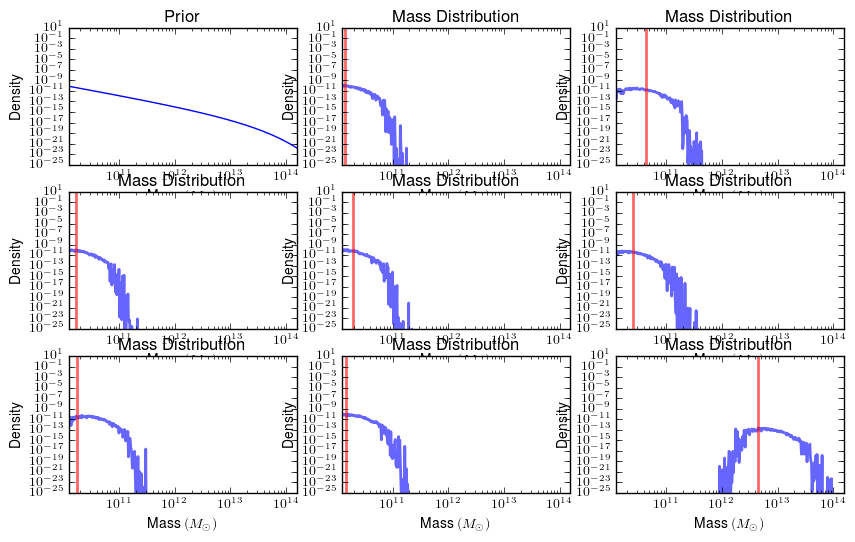

In [159]:
plt.subplot(3,3,1)
dist = p1_eval(zk)
plt.plot(mass_points, dist)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.ylim([10**-25, 10])
plt.xlim([mass_points.min(), mass_points.max()])
plt.title('Prior')
plt.xlabel(r'Mass $(M_\odot)$')
plt.ylabel('Density')

for ind in range(2,9):
    plt.subplot(3,3,ind)
    dist = mass_dist(ind)
    plt.plot(mass_points, dist, alpha=0.6, linewidth=2)
    plt.xlim([mass_points.min(), mass_points.max()])
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.ylim([10**-25, 10])
    plt.gca().axvline(mass_data[ind], color='red', linewidth=2, alpha=0.6)
    plt.title('Mass Distribution')
    plt.xlabel(r'Mass $(M_\odot)$')
    plt.ylabel('Density')
    
    
# most massive
ind = np.argmax(mass_data)
plt.subplot(3,3,9)
dist = mass_dist(ind)
plt.plot(mass_points, dist, alpha=0.6, linewidth=2)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlim([mass_points.min(), mass_points.max()])
plt.ylim([10**-25, 10])
plt.gca().axvline(mass_data[ind], color='red', linewidth=2, alpha=0.6)
plt.title('Mass Distribution')
plt.xlabel(r'Mass $(M_\odot)$')
plt.ylabel('Density')

# plt.tight_layout()
plt.gcf().set_size_inches((10,6))

### Turning into Probabilistic Catalogue

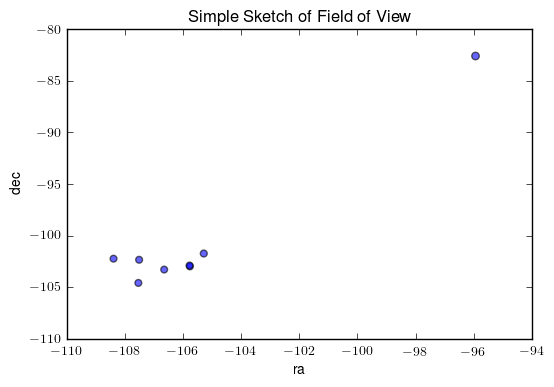

In [168]:
index = range(2,9) + [np.argmax(mass_data)]

plt.title('Simple Sketch of Field of View')
plt.scatter(ra_data[index], dec_data[index] , s=np.log(mass_data[index]), alpha=0.6)
plt.xlabel('ra')
plt.ylabel('dec');

Need to build graphic:
- Make grid that will correspond to pixels
- map ra-dec window to grid
- snap objects onto grid and accumulate mass in each bin of the grid
- plot the grayscale image

# Discussion

- While this is a simple toy model, the consistency between then predicted mass distribution and true mass is encouraging.
- The noise in the mass distribution plots is interesting. The noise increases for masses that are further away than the truth. A similar effect may also exist in bigmali, could it lead to a failure mode?
- In order to build probabilistic mass maps we will need to be able to sample from the mass distributions. One way to do this would be fitting a normal distribution and drawing from that distribution. This will also mitigate the influence of the noise for masses far from the true mass.